Mean Squared Error: 36.48
R-squared Score: 0.49


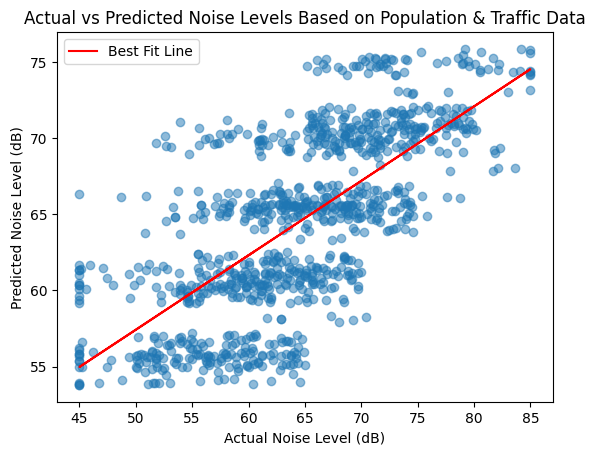

In [8]:
# Importing the relevant libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Loading the noise pollution dataset
noise_data_path = "/content/london_noise_pollution_final.csv"
noise_data = pd.read_csv(noise_data_path)

# Loading the population dataset
population_data_path = "/content/population data.csv"
population_data = pd.read_csv(population_data_path)

# Loading the traffic dataset
traffic_data_path = "/content/traffic-flow-borough.csv"
traffic_data = pd.read_csv(traffic_data_path)

# Renaming the columns for consistency
population_data.rename(columns={"Borough": "Location"}, inplace=True)
traffic_data.rename(columns={"Local Authority": "Location"}, inplace=True)

# Extracting of relevant traffic year data based on noise dataset years that align
traffic_data = traffic_data[['Location', '2015', '2016', '2017', '2018', '2019', '2020', '2021']]
traffic_data = traffic_data.melt(id_vars=['Location'], var_name='Year', value_name='Traffic Volume')
traffic_data['Year'] = traffic_data['Year'].astype(int)

# Merge datasets on 'Location' and 'Year'
df = noise_data.merge(population_data, on="Location", how="left")
df = df.merge(traffic_data, on=["Location", "Year"], how="left")

# Calculate population growth rate
df["Growth Rate"] = (df["Population 2021"] - df["Population 2011"]) / df["Population 2011"]

# One-hot encode 'Time of Day'
df = pd.get_dummies(df, columns=['Time of Day'], drop_first=True)

# Define independent (X) and dependent (y) variables
X = df[['Year', 'Month', 'Population 2011', 'Population 2021', 'Growth Rate', 'Traffic Volume'] + list(df.columns[df.columns.str.startswith('Time of Day_')])]
y = df['Noise Level (dB)']

# Handle missing values for better performance of the machine learning algorithm, based on averages
X = X.fillna(X.mean())

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluation of the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Visualisation of the data with a line of best fit
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Noise Level (dB)")
plt.ylabel("Predicted Noise Level (dB)")
plt.title("Actual vs Predicted Noise Levels Based on Population & Traffic Data")
m, b = np.polyfit(y_test, y_pred, 1)  # Linear regression line
plt.plot(y_test, m*y_test + b, color='red', label="Best Fit Line")
plt.legend()
plt.show()
